In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
total_car_df = pd.read_csv('total_car.csv',na_values=['#VALUE!', '#DIV/0!'],encoding='CP949')
total_boo_df = pd.read_csv('total_boo.csv',na_values=['#VALUE!', '#DIV/0!'],encoding='CP949')
hyundai_df = pd.read_csv('hyundai_car.csv',na_values=['#VALUE!', '#DIV/0!'],encoding='CP949')
gs_df = pd.read_csv('gs_boo.csv',na_values=['#VALUE!', '#DIV/0!'],encoding='CP949')

total_car_df.dropna(inplace=True)
total_boo_df.dropna(inplace=True)
hyundai_df.dropna(inplace=True)
gs_df.dropna(inplace=True)

total_car_df.drop(['거래소코드'],axis=1, inplace=True)
total_boo_df.drop(['거래소코드'],axis=1, inplace=True)
hyundai_df.drop(['거래소코드'],axis=1, inplace=True)
gs_df.drop(['거래소코드'],axis=1, inplace=True)

total_car_df=total_car_df.reset_index()
total_boo_df=total_boo_df.reset_index()
hyundai_df=hyundai_df.reset_index()
gs_df=gs_df.reset_index()

In [10]:
import numpy as np 
import pandas as pd 
import os
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

#### 다중공선성 함수

In [73]:
def get_multicollinearity(dfX):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
    vif["features"] = dfX.columns
    return vif

# lgbm

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [64]:
def feature_importance_plot(best_lgbm, df):
    feature_imp = pd.DataFrame(sorted(zip(best_lgbm.feature_importances_,df.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(30, 20))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    sns.set_context("paper", font_scale=1) 
    plt.title('Feature importance')
    plt.tight_layout()
    plt.show()

### 자동차용 신품 제조업

####  피처 ascii 형태로 이름 바꾸기

영업이익 : profit   
매출총이익 : margin   
당기순이익 : net_income  
매출액 : sales_account    
매출원가 : sales_cost   
자산총계(요약) : asset     
부채총계(요약) : liabilities    
판매비와 관리비 : sa_expenses   
영업이익_차기 : next_profit

In [42]:
car_df=total_car_df[['영업이익','매출총이익','당기순이익','매출액','매출원가','자산총계(요약)','부채총계(요약)','판매비와 관리비','영업이익_차기']]

In [43]:
car_df.columns=['profit', 'margin', 'net_income', 'sales_account', 'sales_cost', 'asset', 'liabilities', 'sa_expenses', 'next_profit']

In [44]:
X_features, y_target= car_df.iloc[:, :-1], car_df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [45]:
lgbm_reg = LGBMRegressor(n_estimators=1000, bagging_fraction=0.7, learning_rate=0.005,
                         max_depth=10, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

In [46]:
lgbm_model = lgbm_reg.fit(X_train, y_train)

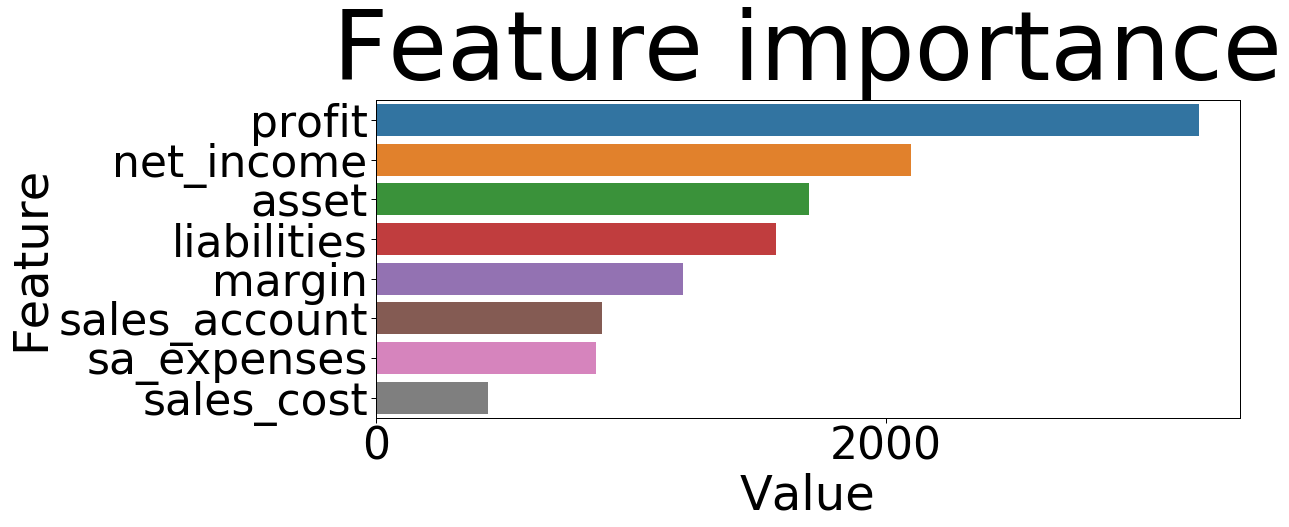

In [52]:
feature_importance_plot(lgbm_reg,car_df)

자동차용 신품 제조업에서는 영업이익, 당기순이익, 자산총계(요약)이 차기영업이익에 영향이 크다.

다중공선성

In [71]:
new_car_df = car_df[['profit', 'net_income', 'asset']]

In [74]:
get_multicollinearity(new_car_df)

,VIF Factor,features
0,15.579437,profit
1,14.006598,net_income
2,4.042983,asset


In [75]:
new_car_df = car_df[['profit', 'asset']]

In [76]:
get_multicollinearity(new_car_df)

,VIF Factor,features
0,3.989493,profit
1,3.989493,asset


#### 자동차용 신품 제조업 feature 선택

다중공선성 고려x: 영업이익, 당기순이익, 자산총계(요약)

다중공선성 고려 : 영업이익, 자산총계

### 단독 주택 건설업

####  피처 ascii 형태로 이름 바꾸기

자산총계(요약) : asset  
자본총계(요약) : capital    
당기순이익 : net_income  
매출액 : sales_account    
매출원가 : sales_cost  
매출총이익 : margin    
판매비와 관리비 : sa_expenses  
영업이익 : profit   
유동자산 : cur_asset  
영업이익_차기 : next_profit

In [54]:
boo_df=total_boo_df[['자산총계(요약)', '자본총계(요약)', '매출액', '매출원가', '매출총이익', '판매비와 관리비', '영업이익', '유동자산','영업이익_차기']]

In [55]:
boo_df.columns = ['capital', 'net_income', 'sales_account', 'sales_cost', 'margin', 'sa_expenses', 'profit', 'cur_asset', 'next_profit']

In [56]:
X_features, y_target= boo_df.iloc[:, :-1], boo_df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [57]:
lgbm_reg = LGBMRegressor(n_estimators=500, bagging_fraction=0.7, learning_rate=0.005,
                         max_depth=7, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

In [58]:
lgbm_model = lgbm_reg.fit(X_train, y_train)

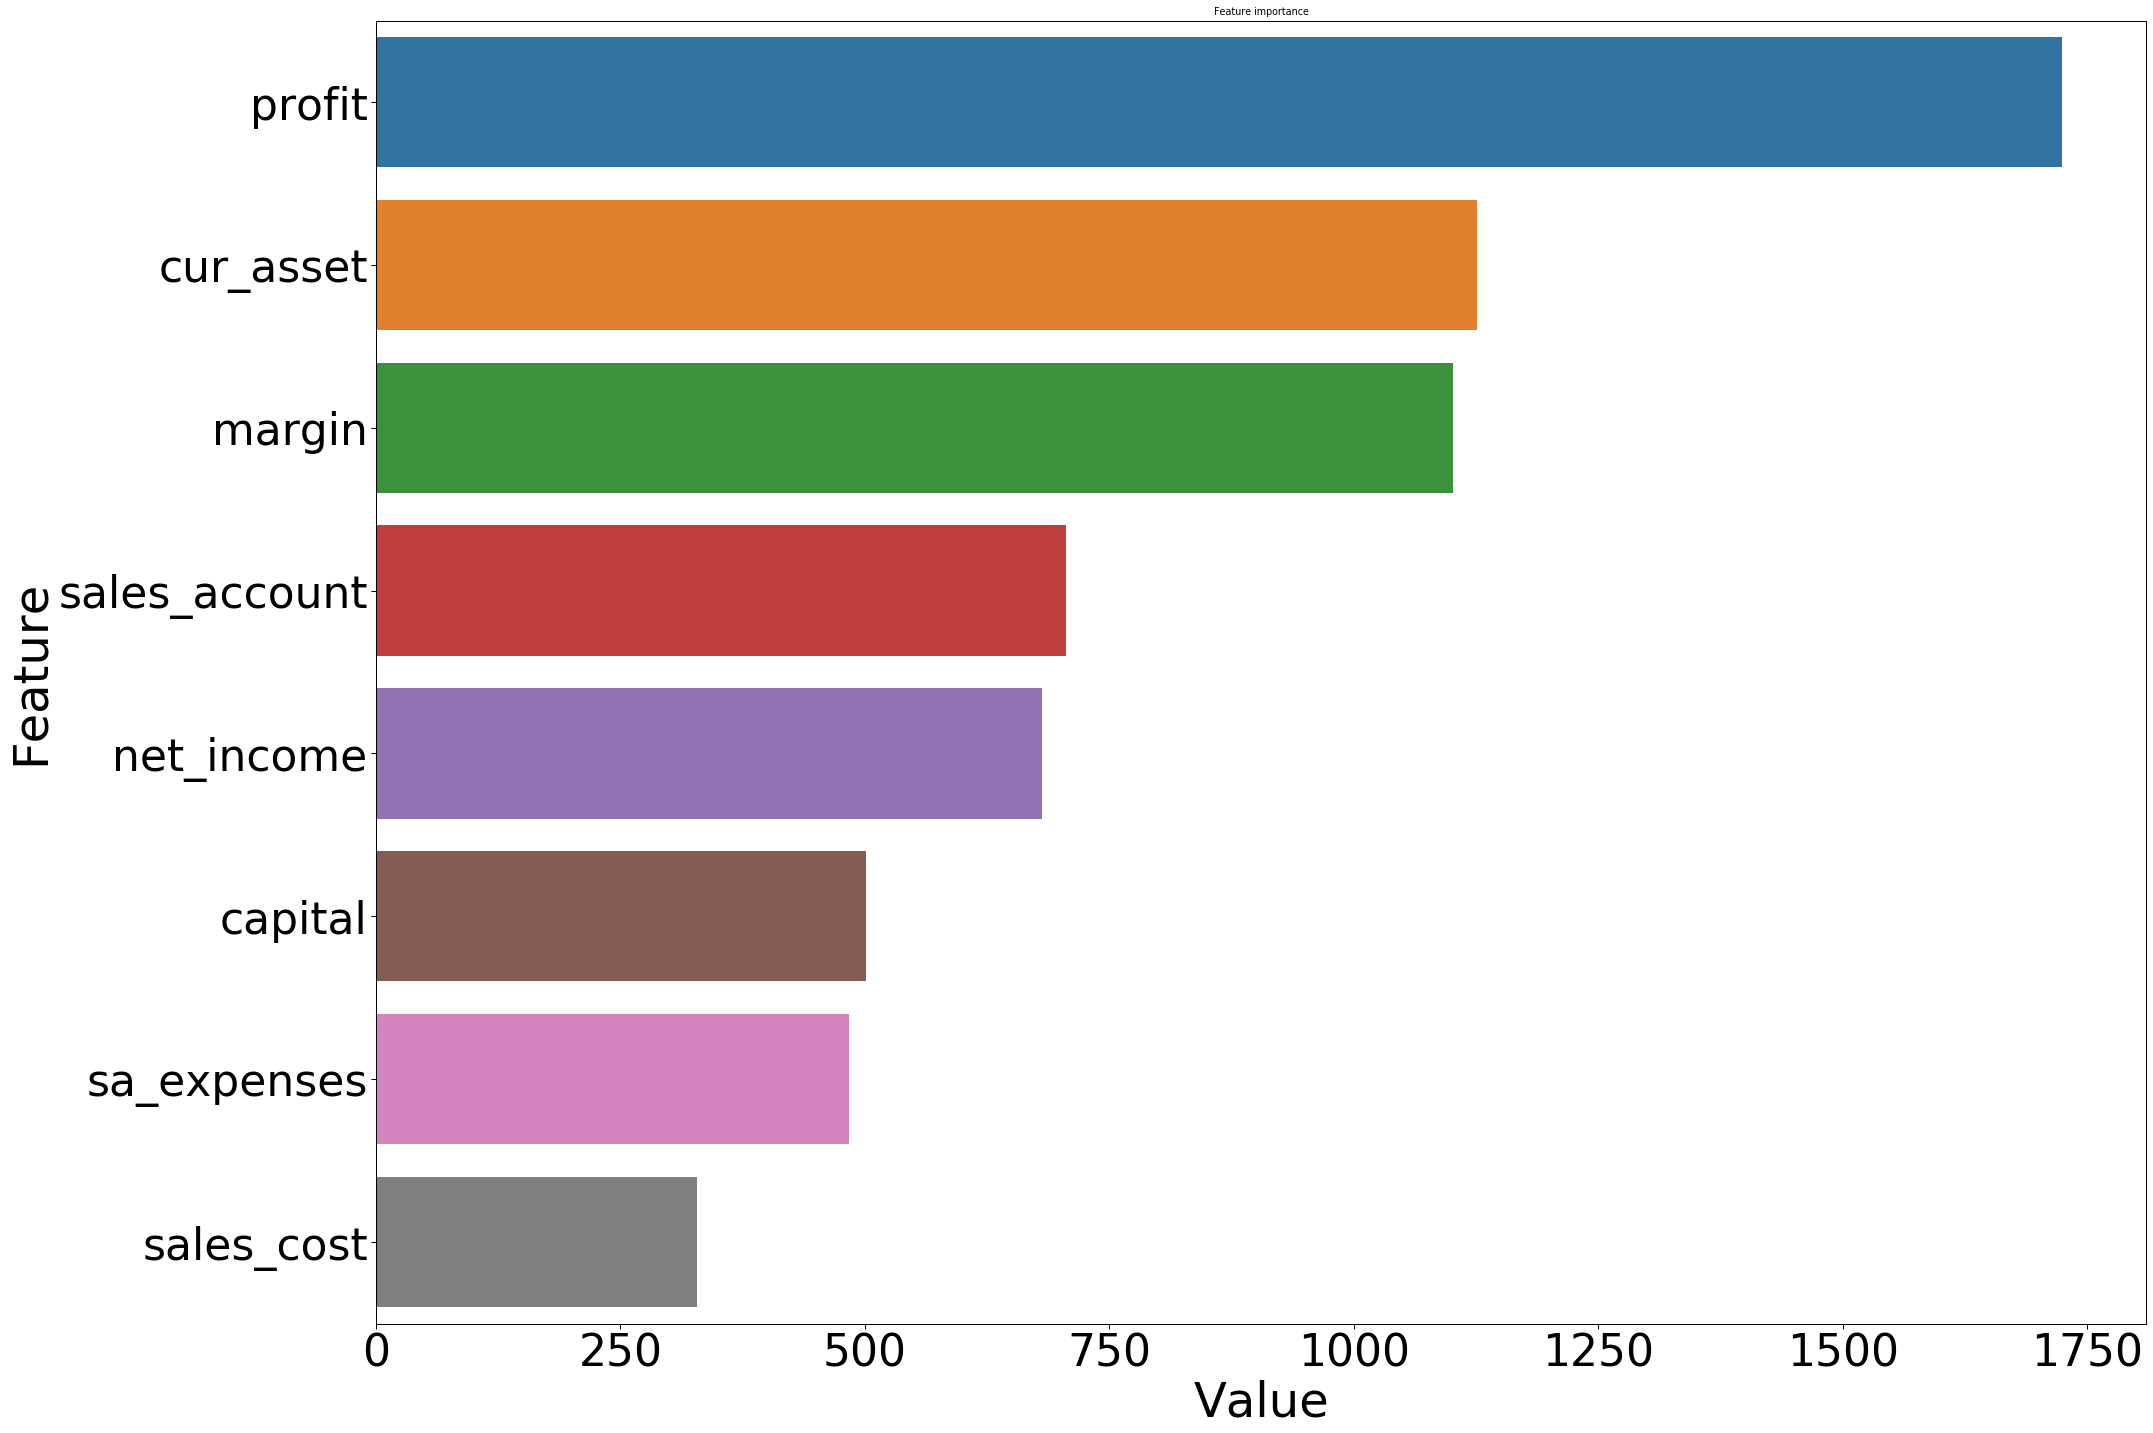

In [65]:
feature_importance_plot(lgbm_reg,boo_df)

단독 주택건설업에서는 영업이익과 유동자산, 매출총이익이 차기 영업이익에 영향이 크다.

다중공선성

In [79]:
new_boo_df = boo_df[['profit', 'cur_asset', 'margin']]

In [80]:
get_multicollinearity(new_boo_df)

,VIF Factor,features
0,8.053887,profit
1,7.585113,cur_asset
2,20.189737,margin


In [81]:
new_boo_df = boo_df[['profit', 'cur_asset']]

In [82]:
get_multicollinearity(new_boo_df)

,VIF Factor,features
0,2.364705,profit
1,2.364705,cur_asset


####  단독 주택 건설업 feature 선택

다중공선성 고려x: 영업이익, 유동자산, 매출총이익

다중공선성 고려 : 영업이익, 유동자산

# XGB

In [86]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [111]:
def feature_importance_plot2(model):  
    featureImportance = model.get_fscore()
    features = pd.DataFrame()
    features['features'] = featureImportance.keys()
    features['importance'] = featureImportance.values()
    features.sort_values(by=['importance'],ascending=False,inplace=True)
    fig,ax= plt.subplots()
    fig.set_size_inches(30,20)
    plt.xticks(rotation=90)
    sns.set_palette("pastel")
    sns.set_context("paper", font_scale=5)
    sns.barplot(data=features.head(5),x="importance",y="features",ax=ax,orient="h", color='pink')

### 자동차용 신품 제조업

In [94]:
car_df=total_car_df[['영업이익','매출총이익','당기순이익','매출액','매출원가','자산총계(요약)','부채총계(요약)','판매비와 관리비','영업이익_차기']]

In [99]:
car_df.columns=['profit', 'margin', 'net_income', 'sales_account', 'sales_cost', 'asset', 'liabilities', 'sa_expenses', 'next_profit']

In [100]:
X_features, y_label= car_df.iloc[:, :-1], car_df.iloc[:, -1]
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.3, random_state=156 )
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train) 

In [101]:
xgb_params = {
    'eta': 0.05,
    'learning_rate': 0.1,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'silent': 1
}
model = xgb.train(dict(xgb_params, silent=0), train_dmatrix, num_boost_round=100)

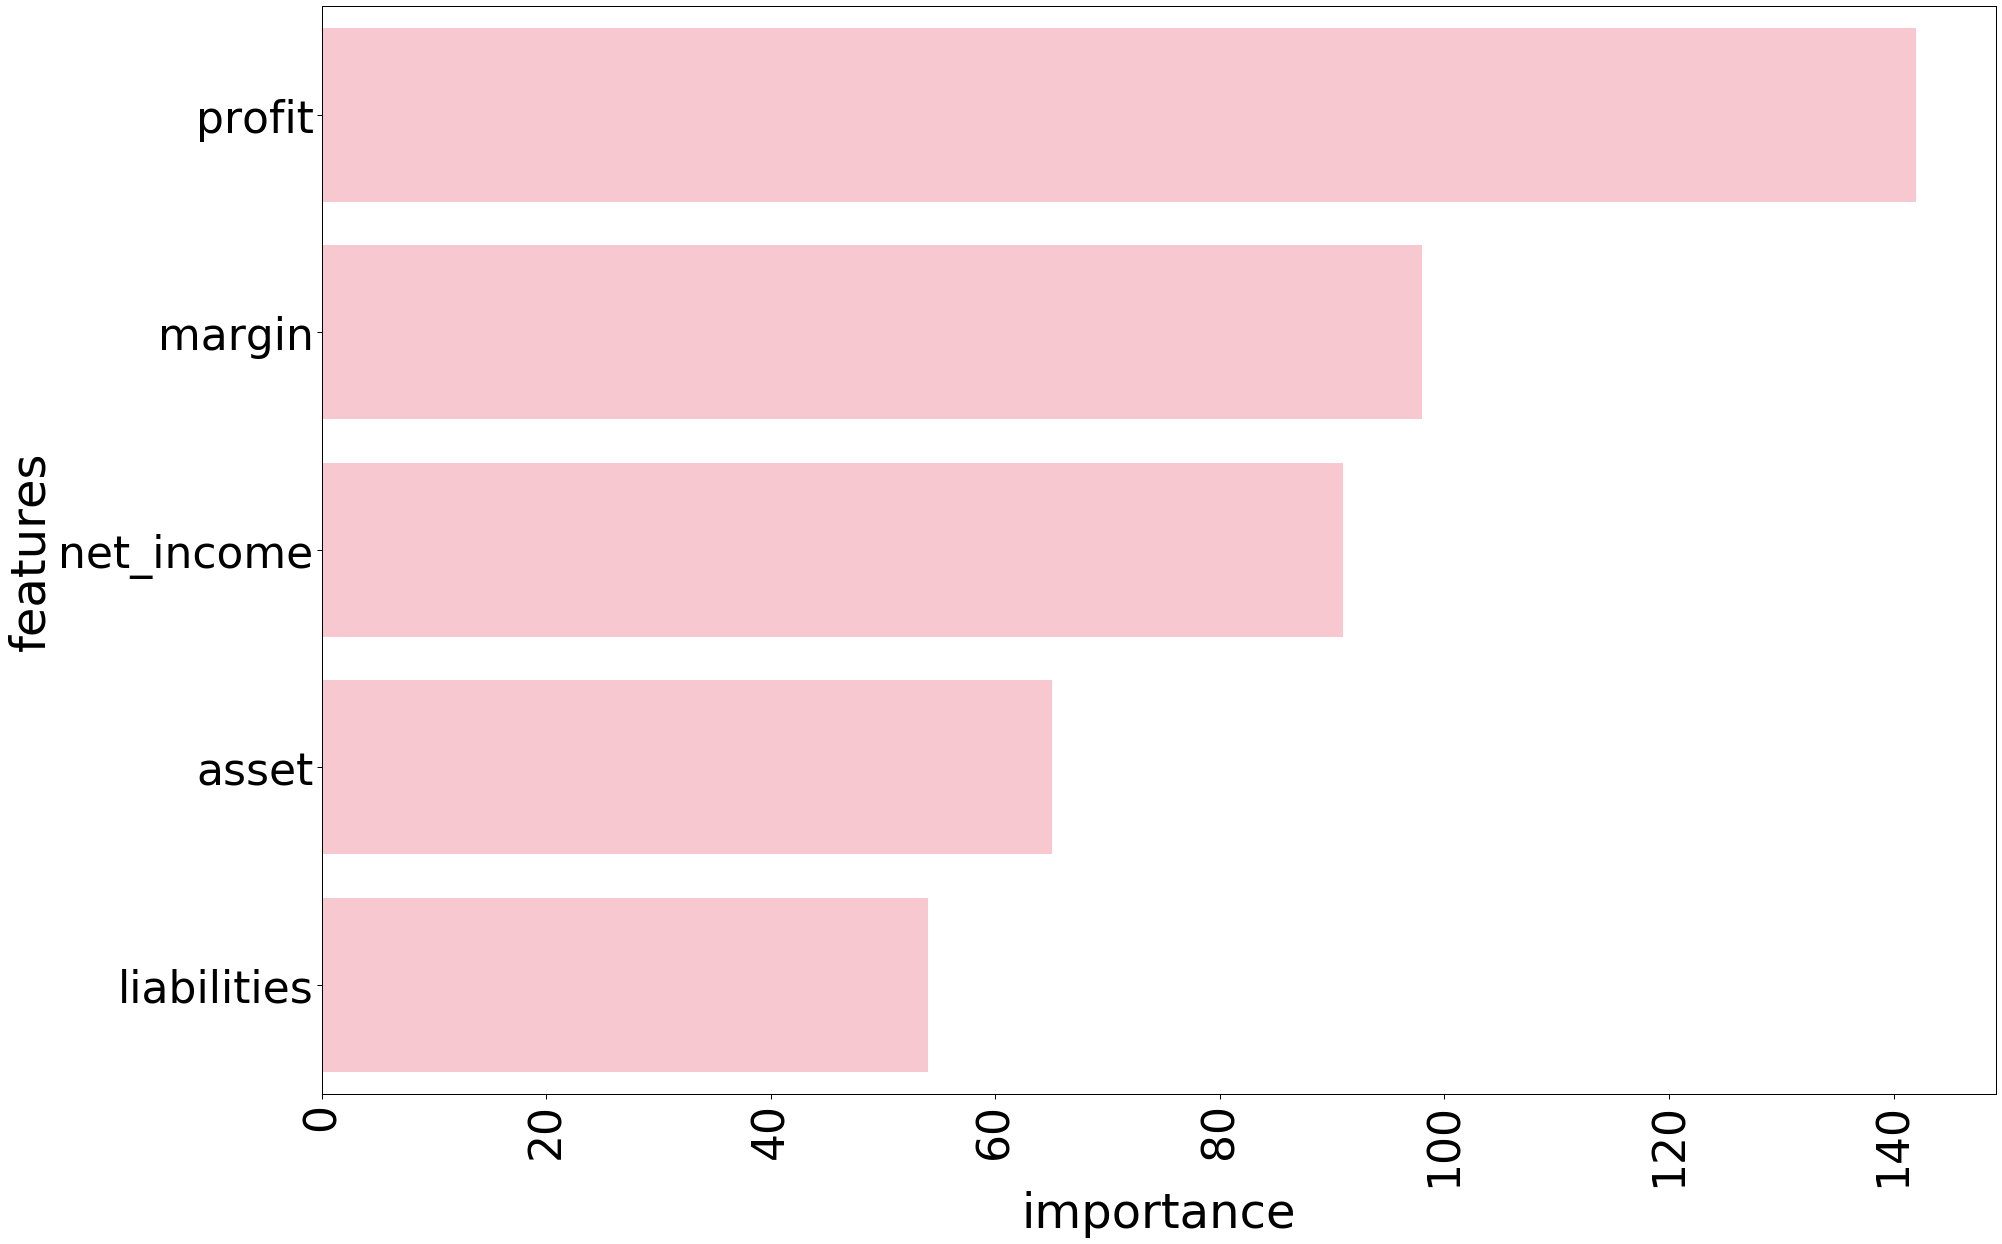

In [112]:
feature_importance_plot2(model)

자동차용 신품 제조업에서는 영업이익, 당기순이익, 매출총이익이 차기영업이익에 영향이 크다.

In [118]:
new_car_df = car_df[['profit', 'margin', 'net_income']]
get_multicollinearity(new_car_df)

,VIF Factor,features
0,21.553929,profit
1,8.085909,margin
2,13.836559,net_income


In [119]:
new_car_df = car_df[['profit', 'margin']]
get_multicollinearity(new_car_df)

,VIF Factor,features
0,8.076983,profit
1,8.076983,margin


#### 자동차용 신품 제조업 feature 선택

다중공선성 고려x: 영업이익, 당기순이익, 매출총이익

다중공선성 고려 : 영업이익, 당기순이익

### 단독 주택 건설업

In [120]:
boo_df=total_boo_df[['자산총계(요약)', '자본총계(요약)', '매출액', '매출원가', '매출총이익', '판매비와 관리비', '영업이익', '유동자산','영업이익_차기']]

In [121]:
boo_df.columns = ['capital', 'net_income', 'sales_account', 'sales_cost', 'margin', 'sa_expenses', 'profit', 'cur_asset', 'next_profit']

In [127]:
X_features, y_label= boo_df.iloc[:, :-1], boo_df.iloc[:, -1]
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.3, random_state=156 )
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train) 

In [128]:
xgb_params = {
    'eta': 0.05,
    'learning_rate': 0.1,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'silent': 1
}
model = xgb.train(dict(xgb_params, silent=0), train_dmatrix, num_boost_round=100)

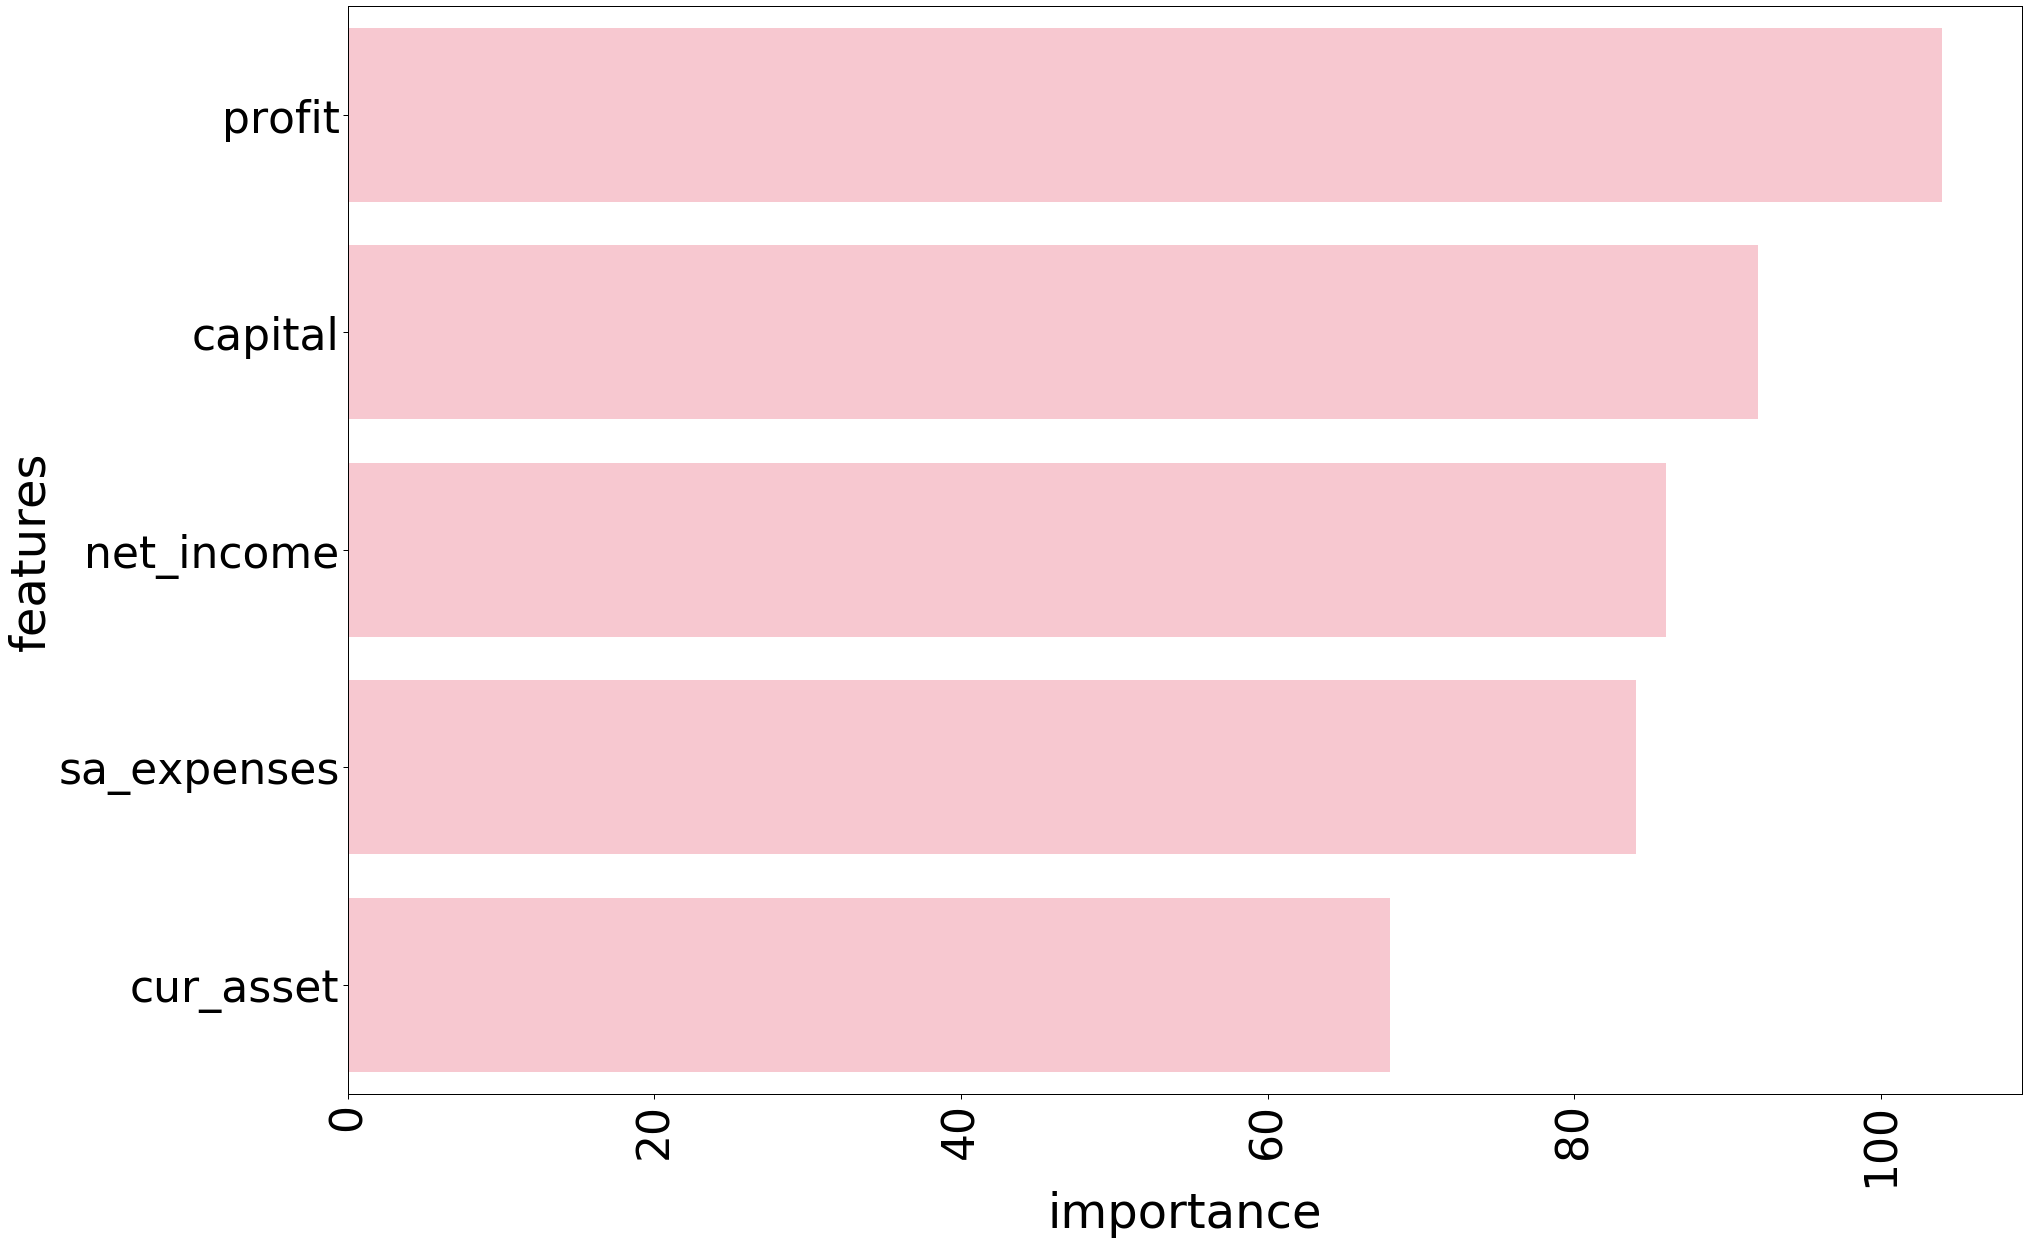

In [129]:
feature_importance_plot2(model)

단독 주택 건설업에서는 영업이익, 자본총계(요약), 당기순이익, 판매비와 관리비가 차기영업이익에 영향이 크다.

In [134]:
new_boo_df = boo_df[['profit', 'capital', 'net_income', 'sa_expenses']]
get_multicollinearity(new_boo_df)

,VIF Factor,features
0,2.804306,profit
1,14.780276,capital
2,8.368147,net_income
3,7.721723,sa_expenses


In [131]:
new_boo_df = boo_df[['profit', 'capital', 'net_income']]
get_multicollinearity(new_boo_df)

,VIF Factor,features
0,2.609667,profit
1,7.875125,capital
2,8.272966,net_income


#### 단독 주택 건설업 feature 선택

다중공선성 고려x: 영업이익, 자본총계(요약), 당기순이익, 판매비와 관리비

다중공선성 고려x: 영업이익, 자본총계(요약), 당기순이익